Split the last year into a test set- can you build a model to predict energy consumption?

Find trends in energy consumption around hours of the day, holidays, or long term trends?

Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import plotly.graph_objects as go
from sklearn.inspection import permutation_importance



In [2]:
df = pd.read_csv('/Users/alexvalles/PJME_hourly.csv')
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [3]:
df = df.set_index('Datetime')

In [4]:
df.index = pd.to_datetime(df.index)

df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [5]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [6]:
df.dtypes

PJME_MW    float64
dtype: object

In [7]:
df.isnull().sum()

PJME_MW    0
dtype: int64

Text(0.5, 0, 'Date')

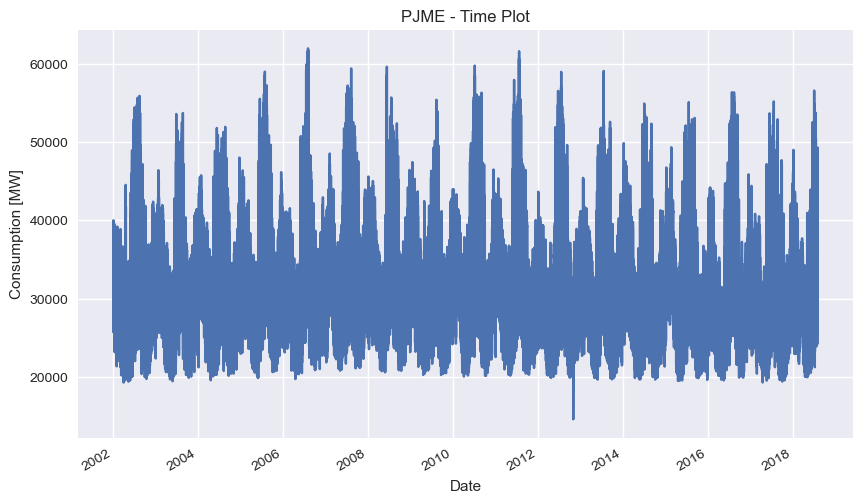

In [8]:
# Set pyplot style
plt.style.use("seaborn")

# Plot
df['PJME_MW'].plot(title='PJME - Time Plot', figsize=(10,6))
plt.ylabel('Consumption [MW]')
plt.xlabel('Date')

TRAIN TEST SPLIT


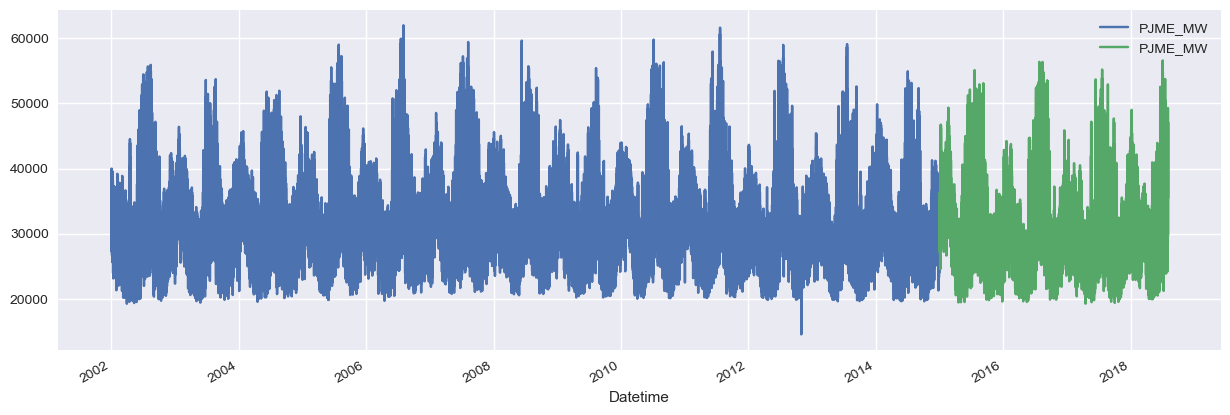

In [9]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label='Test set')
plt.show()

In [10]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]

,PJME_MW
Datetime,
2010-01-07 01:00:00,32194.0
2010-01-07 02:00:00,31254.0
2010-01-07 03:00:00,30894.0
2010-01-07 04:00:00,30937.0
2010-01-07 05:00:00,31660.0
...,...
2010-01-01 20:00:00,35385.0
2010-01-01 21:00:00,35105.0
2010-01-01 22:00:00,34309.0


<Axes: xlabel='Datetime'>

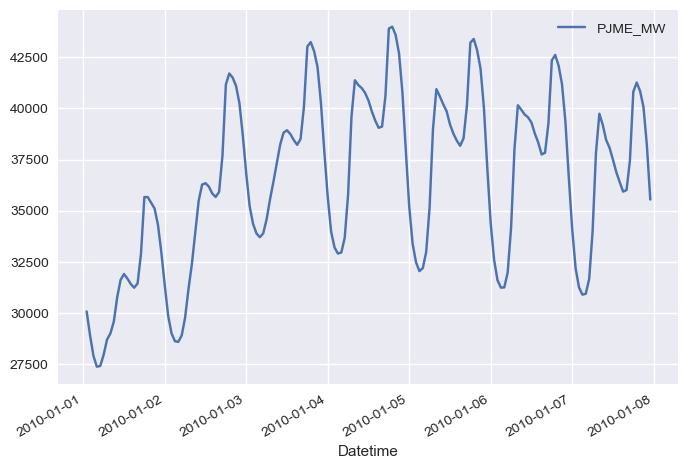

In [11]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot()

Variable creation:

In [12]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.day_of_week
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear



In [13]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1
2018-01-01 23:00:00,40164.0,23,0,1,1,2018,1
2018-01-02 00:00:00,38608.0,0,1,1,1,2018,2


In [14]:
# create df based on time series index


def create_features(df):

    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df

df = create_features(df)

In [15]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


Visualize feature / Target relationship

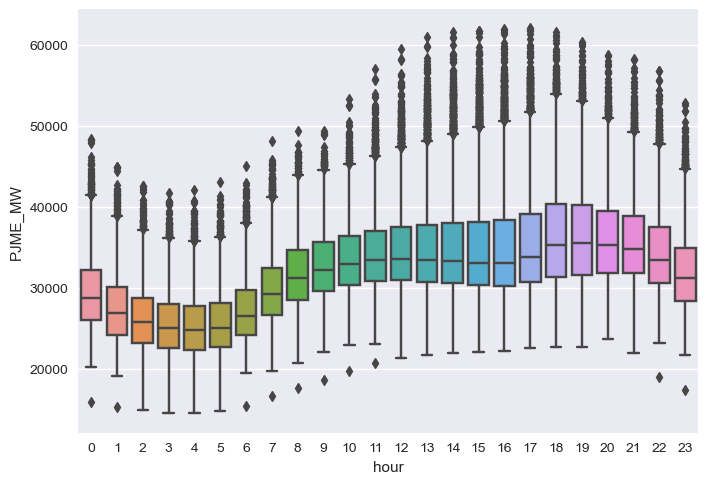

In [16]:
sns.boxplot(data=df, x='hour', y= 'PJME_MW')
ax.set_title('MW by hour')
plt.show()

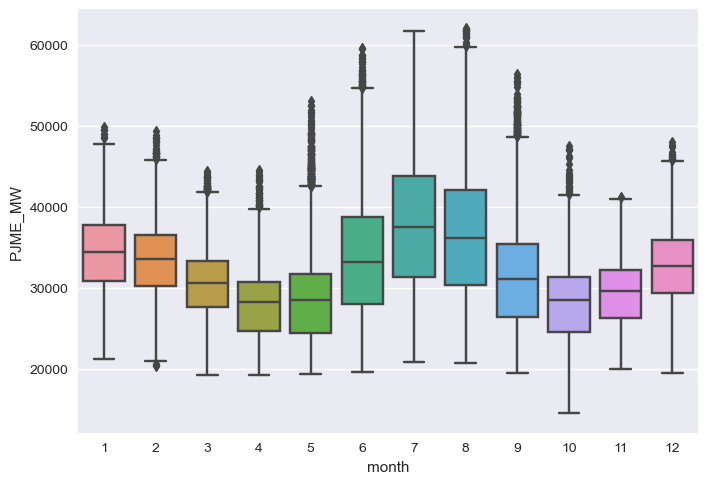

In [17]:
sns.boxplot(data=df, x='month', y= 'PJME_MW')
ax.set_title('MW by month')
plt.show()

CREATE MODEL

In [18]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [19]:
train = create_features(train)
test = create_features(test)

In [20]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [21]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET = 'PJME_MW'

In [22]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [24]:
reg = xgb.XGBRFRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:3407.59383	validation_1-rmse:3973.47504


XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=1000, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [25]:
reg = xgb.XGBRFRegressor(n_estimators=1000, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6408.08334	validation_1-rmse:6480.70229


XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=1000, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, ...)

FEATURE IMPORTANCE

In [26]:
reg.feature_importances_

array([0.34282434, 0.15201783, 0.1238987 , 0.22470647, 0.0105711 ,
       0.14598152], dtype=float32)

In [27]:
feat_imp= pd.DataFrame(data= reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])

In [28]:
feat_imp

,importance
hour,0.342824
dayofweek,0.152018
quarter,0.123899
month,0.224706
year,0.010571
dayofyear,0.145982


<function matplotlib.pyplot.show(close=None, block=None)>

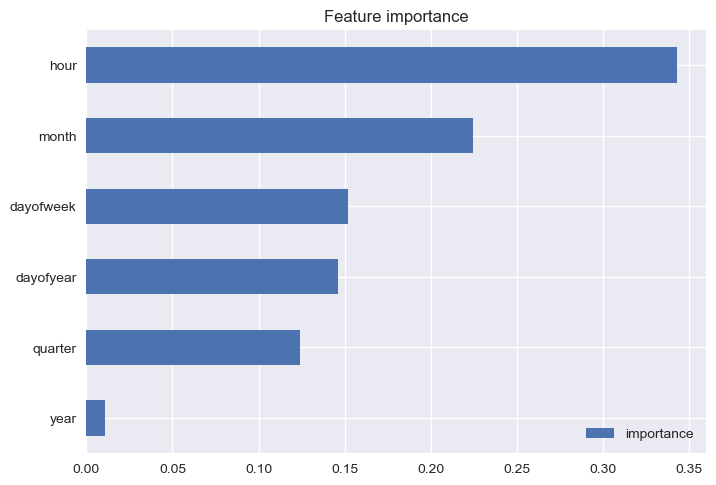

In [29]:
feat_imp.sort_values('importance').plot(kind='barh', title='Feature importance')
plt.show

FORECAST ON TEST

In [30]:
test['prediction'] = reg.predict(X_test)

In [31]:
df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,32399.279297
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,32399.279297
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,32395.556641


In [32]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)



In [33]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,32399.279297
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,32399.279297
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,32395.556641


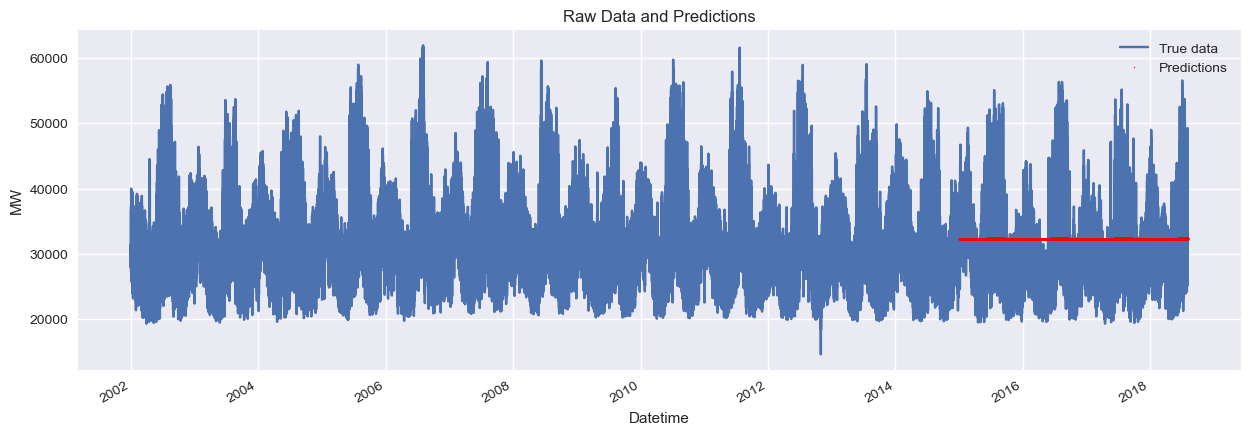

In [34]:
ax = df[['PJME_MW']].plot(figsize=(15,5), legend=True)
df['prediction'].plot(ax=ax, style='.', markersize=2, color='red', legend=True)
plt.legend(['True data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
ax.set_xlabel('Datetime')
ax.set_ylabel('MW')
plt.show()